# Twin Premixed Counter-Flow Flame Example

This example documents how to simulate two identical, axisymmetric, premixed jets of reactants shooting into each other. An illustration of this configuration is shown in the figure below

![Twin Premixed Flame](images/twinPremixedFlame.png)

### Import modules

In [1]:
from __future__ import print_function
from __future__ import division

import cantera as ct
import numpy as np

print("Running Cantera Version: " + str(ct.__version__))

Running Cantera Version: 2.3.0a3


### Define the reactant conditions, gas mixture and kinetic mechanism associated with the gas

In [2]:
#Inlet Temperature in Kelvin and Inlet Pressure in Pascals
#In this case we are setting the inlet T and P to room temperature conditions
To = 300
Po = 101325

#Define the gas-mixutre and kinetics
#In this case, we are choosing a GRI3.0 gas
gas = ct.Solution('gri30.cti')

# Create a CH4/Air premixed mixture with equivalence ratio=0.75
gas.set_equivalence_ratio(0.75, 'CH4', {'O2':1.0, 'N2':3.76})
gas.TP = To, Po

# Set the velocity of the reactants
# This is what determines the strain-rate
axial_velocity = 2.0 # in m/s

# Done with initial conditions
# Compute the mass flux, as this is what the Flame object requires
massFlux = gas.density * axial_velocity # units kg/m2/s


### Define functions

In [3]:
# Differentiation function for data that has variable grid spacing Used here to
# compute normal strain-rate
def derivative(x, y):
    dydx = np.zeros(y.shape, y.dtype.type)

    dx = np.diff(x)
    dy = np.diff(y)
    dydx[0:-1] = dy/dx

    dydx[-1] = (y[-1] - y[-2])/(x[-1] - x[-2])

    return dydx

def computeStrainRates(oppFlame):
    # Compute the derivative of axial velocity to obtain normal strain rate
    strainRates = derivative(oppFlame.grid, oppFlame.u)

    # Obtain the location of the max. strain rate upstream of the pre-heat zone.
    # This is the characteristic strain rate
    maxStrLocation = abs(strainRates).argmax()
    minVelocityPoint = oppFlame.u[:maxStrLocation].argmin()

    # Characteristic Strain Rate = K
    strainRatePoint = abs(strainRates[:minVelocityPoint]).argmax()
    K = abs(strainRates[strainRatePoint])

    return strainRates, strainRatePoint, K

def computeConsumptionSpeed(oppFlame):

    Tb = max(oppFlame.T)
    Tu = min(oppFlame.T)
    rho_u = max(oppFlame.density)

    integrand = oppFlame.heat_release_rate/oppFlame.cp

    I = np.trapz(integrand, oppFlame.grid)
    Sc = I/(Tb - Tu)/rho_u

    return Sc

# This function is called to run the solver
def solveOpposedFlame(oppFlame, massFlux=0.12, loglevel=0,
                      ratio=2, slope=0.3, curve=0.3, prune=0.05):
    """
    Execute this function to run the Oppposed Flow Simulation This function
    takes a CounterFlowTwinPremixedFlame object as the first argument
    """

    oppFlame.reactants.mdot = massFlux
    oppFlame.set_refine_criteria(ratio=ratio, slope=slope, curve=curve, prune=prune)

    oppFlame.show_solution()
    oppFlame.solve(loglevel, auto=True)

    # Compute the strain rate, just before the flame. This is not necessarily
    # the maximum We use the max. strain rate just upstream of the pre-heat zone
    # as this is the strain rate that computations comprare against, like when
    # plotting Su vs. K
    strainRates, strainRatePoint, K = computeStrainRates(oppFlame)

    return np.max(oppFlame.T), K, strainRatePoint

### Define a flame object, domain width and tranport model

In [4]:
# Define a domain half-width of 2.5 cm, meaning the whole domain is 5 cm wide
width = 0.025

# Create the flame object
oppFlame = ct.CounterflowTwinPremixedFlame(gas, width=width)

# Uncomment the following line to use a Multi-component formulation. Default is
# mixture-averaged
#oppFlame.transport_model = 'Multi'

### Run the Solver

In [5]:
# The solver returns the peak temperature, strain rate and
# the point which we ascribe to the characteristic strain rate.

(T, K, strainRatePoint) = solveOpposedFlame(oppFlame, massFlux, loglevel=1)

# You can plot/see all state space variables by calling oppFlame.foo where foo
# is T, Y[i], etc. The spatial variable (distance in meters) is in oppFlame.grid
# Thus to plot temperature vs distance, use oppFlame.grid and oppFlame.T

#This is to save output
oppFlame.write_csv("premixed_twin_flame.csv", quiet=False)



>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> reactants <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

    Mass Flux:        2.268 kg/m^2/s 
    Temperature:        300 K 
    Mass Fractions: 
                      O2      0.2232 
                     CH4     0.04197 
                      N2      0.7348 



>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> flame <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

    Pressure:   1.013e+05 Pa

-------------------------------------------------------------------------------
          z           u           V           T      lambda          H2 
-------------------------------------------------------------------------------
          0           2           0         300           0           0 
      0.005         1.6          32         300           0           0 
       0.01         1.2          64         300           0    2.06e-21 
     0.0125           1          80        1110           0   3.711e-06 
      0.015         0.8          96        1920           0   7.422e-06 
       0.

In [6]:
Sc = computeConsumptionSpeed(oppFlame)

print("Peak temperature: {0:.1f} K".format(T))
print("Strain Rate: {0:.1f} 1/s".format(K))
print("Consumption Speed: {0:.2f} cm/s".format(Sc*100))

Peak temperature: 1920.5 K
Strain Rate: 163.6 1/s
Consumption Speed: 20.80 cm/s


### Plot figures

Note that the graphs only represent one-half of the domain, because the solution is symmetric

In [7]:
# Import plotting modules and define plotting preference
import pylab as plt
%matplotlib notebook

plt.rcParams['figure.autolayout'] = True

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['figure.figsize'] = (8,6)

#### Axial velocity plot

<IPython.core.display.Javascript object>


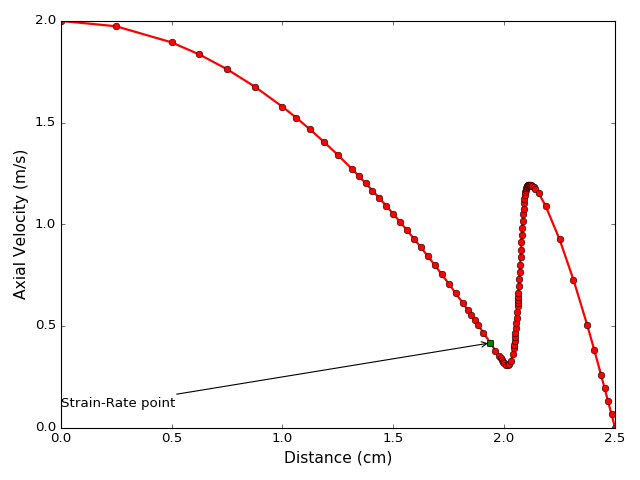

In [8]:
plt.figure()

plt.plot(oppFlame.grid*100, oppFlame.u, 'r-o', lw=2)
plt.xlim(oppFlame.grid[0], oppFlame.grid[-1]*100)
plt.xlabel('Distance (cm)')
plt.ylabel('Axial Velocity (m/s)')

# Identify the point where the strain rate is calculated
plt.plot(oppFlame.grid[strainRatePoint]*100, oppFlame.u[strainRatePoint],'gs')
plt.annotate('Strain-Rate point',
             xy=(oppFlame.grid[strainRatePoint]*100, oppFlame.u[strainRatePoint]),
             xytext=(0.001, 0.1),
             arrowprops={'arrowstyle':'->'});

#### Temperature Plot

<IPython.core.display.Javascript object>


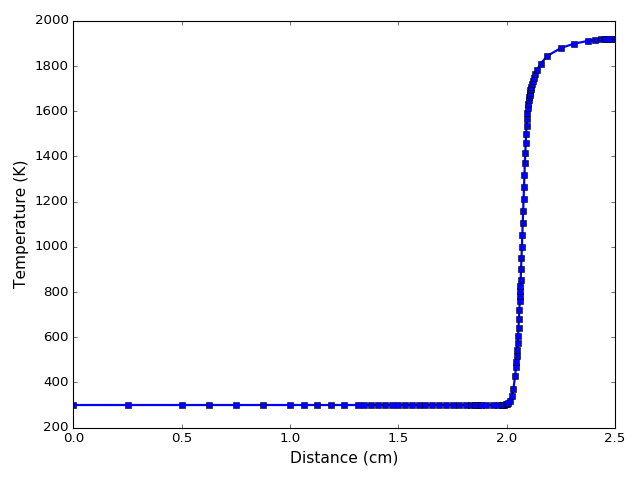

In [9]:
plt.figure()

plt.plot(oppFlame.grid*100, oppFlame.T, 'b-s', lw=2)
plt.xlim(oppFlame.grid[0], oppFlame.grid[-1]*100)
plt.xlabel('Distance (cm)')
plt.ylabel('Temperature (K)');

#### Major Species' Plot

<IPython.core.display.Javascript object>


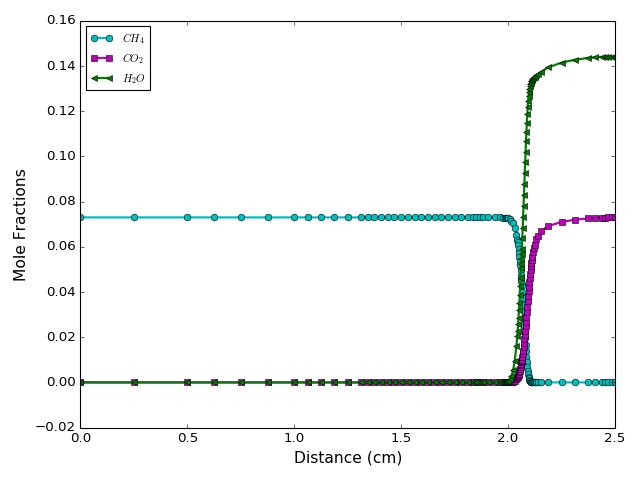

In [10]:
"""
# To plot species, we first have to identify the index of the species in the array
# For this, cut & paste the following lines and run in a new cell to get the index
for i, specie in enumerate(gas.species()):
    print(str(i) + '. ' + str(specie))
"""

# Extract concentration data
X_CH4 = oppFlame.X[13]
X_CO2 = oppFlame.X[15]
X_H2O = oppFlame.X[5]

plt.figure()

plt.plot(oppFlame.grid*100, X_CH4, 'c-o', lw=2, label=r'$CH_{4}$')
plt.plot(oppFlame.grid*100, X_CO2, 'm-s', lw=2, label=r'$CO_{2}$')
plt.plot(oppFlame.grid*100, X_H2O, 'g-<', lw=2, label=r'$H_{2}O$')

plt.xlim(oppFlame.grid[0], oppFlame.grid[-1]*100)
plt.xlabel('Distance (cm)')
plt.ylabel('Mole Fractions')

plt.legend(loc=2);